In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['sample_submission.csv', 'plates.zip']
After zip extraction:
['__notebook__.ipynb', '__MACOSX', 'plates']


In [2]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['test', 'train', '.DS_Store']


In [3]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 5671.63it/s]


In [4]:
!ls train

cleaned  dirty


In [5]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

In [6]:


from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.0, contrast=0.0, saturation=0.0, hue=0.0),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50),
    #transforms.RandomGrayscale(p=0.25),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)

# aug experiments
print(type(train_dataset))


val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 16
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

<class 'torchvision.datasets.folder.ImageFolder'>


In [7]:
len(train_dataloader), len(train_dataset)

(2, 32)

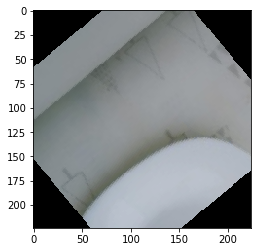

In [8]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

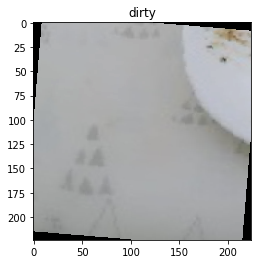

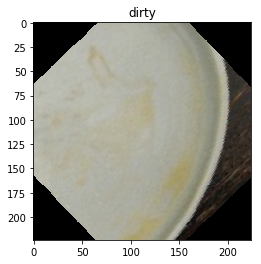

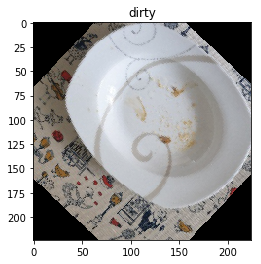

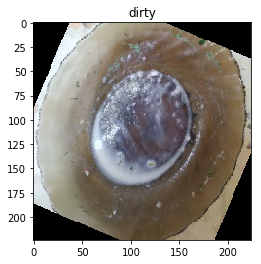

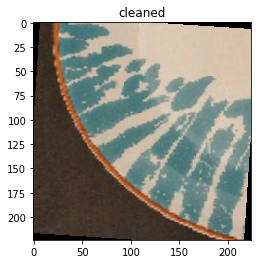

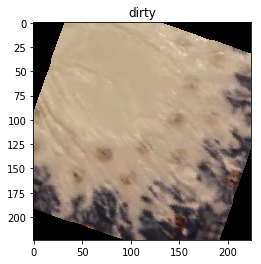

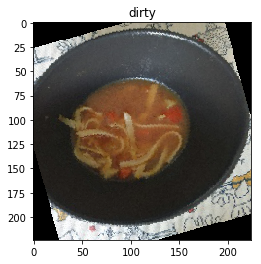

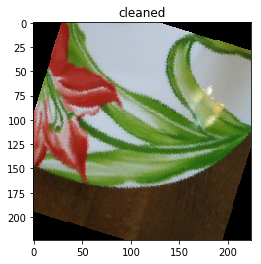

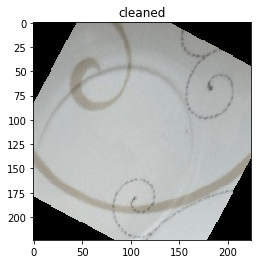

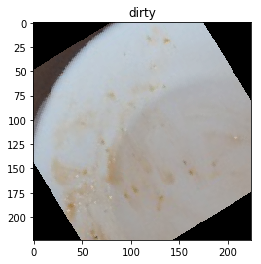

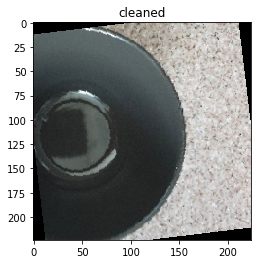

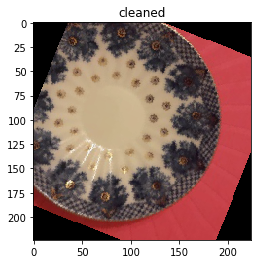

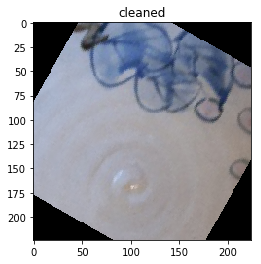

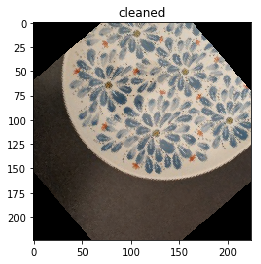

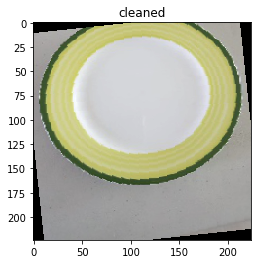

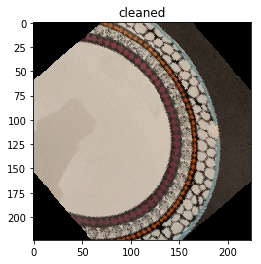

In [9]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [10]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    return model

In [11]:
#model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
#for param in model.parameters():
#    param.requires_grad = False

#model.fc = torch.nn.Linear(model.fc.in_features, 2)

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = model.to(device)

#loss = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [12]:
from torchvision import transforms, models
model = models.mobilenet_v2(pretrained = True)


# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[1].in_features

model.classifier[1] = torch.nn.Sequential(
    torch.nn.Linear(model.classifier[1].in_features, 4096),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.5),
    torch.nn.Tanh(),
    torch.nn.Linear(4096, 1280),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(model.classifier[1].in_features, 2)
    )


#model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 4096)
#model.classifier[2] = torch.nn.ReLU(inplace=True)
#model.classifier[3] = torch.nn.Dropout(p=0.5)
#model.classifier[4] = torch.nn.Linear(model.classifier[1].in_features, 2)

#model.fc = torch.nn.Linear(model.fc.in_features, 2)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.05)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 14212972/14212972 [00:00<00:00, 75209492.05it/s]


In [13]:
model.named_children

<bound method Module.named_children of MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1

In [14]:
print(type(model.classifier[-1]))

<class 'torch.nn.modules.container.Sequential'>


In [15]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7120 Acc: 0.4375


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

val Loss: 0.6985 Acc: 0.5000
Epoch 1/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6951 Acc: 0.5625


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

val Loss: 0.6966 Acc: 0.5000
Epoch 2/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7082 Acc: 0.4062


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

val Loss: 0.6958 Acc: 0.2500
Epoch 3/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6729 Acc: 0.6250


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

val Loss: 0.6919 Acc: 0.6250
Epoch 4/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6810 Acc: 0.5312


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

val Loss: 0.6906 Acc: 0.5000
Epoch 5/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6577 Acc: 0.7500


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

val Loss: 0.6887 Acc: 0.7500
Epoch 6/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6438 Acc: 0.8125


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

val Loss: 0.6894 Acc: 0.7500
Epoch 7/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6446 Acc: 0.7500


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

val Loss: 0.6897 Acc: 0.7500
Epoch 8/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6594 Acc: 0.6875


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

val Loss: 0.6903 Acc: 0.7500
Epoch 9/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6826 Acc: 0.6250


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

val Loss: 0.6910 Acc: 0.7500
Epoch 10/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6565 Acc: 0.6562


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

val Loss: 0.6899 Acc: 0.7500
Epoch 11/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6627 Acc: 0.6250


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

val Loss: 0.6897 Acc: 0.7500
Epoch 12/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6376 Acc: 0.7812


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

val Loss: 0.6890 Acc: 0.6250
Epoch 13/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6350 Acc: 0.7500


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

val Loss: 0.6878 Acc: 0.7500
Epoch 14/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6377 Acc: 0.7812


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

val Loss: 0.6882 Acc: 0.6250
Epoch 15/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6431 Acc: 0.7812


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

val Loss: 0.6875 Acc: 0.6250
Epoch 16/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6484 Acc: 0.6250


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

val Loss: 0.6870 Acc: 0.7500
Epoch 17/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6549 Acc: 0.6250


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

val Loss: 0.6873 Acc: 0.7500
Epoch 18/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6308 Acc: 0.7188


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

val Loss: 0.6869 Acc: 0.7500
Epoch 19/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6215 Acc: 0.8750


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

val Loss: 0.6882 Acc: 0.6250
Epoch 20/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6504 Acc: 0.7500


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

val Loss: 0.6890 Acc: 0.6250
Epoch 21/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6723 Acc: 0.6250


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

val Loss: 0.6879 Acc: 0.6250
Epoch 22/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6397 Acc: 0.7188


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

val Loss: 0.6888 Acc: 0.5000
Epoch 23/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6312 Acc: 0.7812


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


val Loss: 0.6871 Acc: 0.5000
Epoch 24/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6599 Acc: 0.7188


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

val Loss: 0.6890 Acc: 0.5000
Epoch 25/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6668 Acc: 0.5938


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

val Loss: 0.6883 Acc: 0.5000
Epoch 26/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6440 Acc: 0.7812


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

val Loss: 0.6900 Acc: 0.5000
Epoch 27/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6559 Acc: 0.5625


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

val Loss: 0.6897 Acc: 0.5000
Epoch 28/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6403 Acc: 0.7188


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

val Loss: 0.6892 Acc: 0.6250
Epoch 29/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6692 Acc: 0.6875


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

val Loss: 0.6891 Acc: 0.6250
Epoch 30/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6485 Acc: 0.7188


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

val Loss: 0.6883 Acc: 0.6250
Epoch 31/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6529 Acc: 0.6562


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

val Loss: 0.6883 Acc: 0.6250
Epoch 32/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6400 Acc: 0.8125


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

val Loss: 0.6880 Acc: 0.6250
Epoch 33/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6769 Acc: 0.5625


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

val Loss: 0.6875 Acc: 0.6250
Epoch 34/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6591 Acc: 0.6562


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

val Loss: 0.6880 Acc: 0.5000
Epoch 35/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6397 Acc: 0.7812


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

val Loss: 0.6885 Acc: 0.6250
Epoch 36/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6657 Acc: 0.7188


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

val Loss: 0.6882 Acc: 0.6250
Epoch 37/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6402 Acc: 0.7188


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

val Loss: 0.6892 Acc: 0.6250
Epoch 38/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6510 Acc: 0.6562


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

val Loss: 0.6903 Acc: 0.5000
Epoch 39/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6492 Acc: 0.7188


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

val Loss: 0.6887 Acc: 0.6250
Epoch 40/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6753 Acc: 0.5938


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

val Loss: 0.6885 Acc: 0.6250
Epoch 41/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6358 Acc: 0.7188


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

val Loss: 0.6885 Acc: 0.5000
Epoch 42/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6522 Acc: 0.6562


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

val Loss: 0.6894 Acc: 0.6250
Epoch 43/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6472 Acc: 0.7500


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

val Loss: 0.6903 Acc: 0.5000
Epoch 44/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6560 Acc: 0.6250


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

val Loss: 0.6914 Acc: 0.6250
Epoch 45/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6526 Acc: 0.6875


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

val Loss: 0.6914 Acc: 0.6250
Epoch 46/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6606 Acc: 0.7188


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

val Loss: 0.6906 Acc: 0.5000
Epoch 47/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6384 Acc: 0.7500


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

val Loss: 0.6908 Acc: 0.5000
Epoch 48/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6714 Acc: 0.5312


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

val Loss: 0.6906 Acc: 0.6250
Epoch 49/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6418 Acc: 0.7500


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

val Loss: 0.6906 Acc: 0.6250
Epoch 50/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6264 Acc: 0.7500


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

val Loss: 0.6906 Acc: 0.6250
Epoch 51/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6584 Acc: 0.6562


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

val Loss: 0.6902 Acc: 0.6250
Epoch 52/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6470 Acc: 0.6250


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

val Loss: 0.6909 Acc: 0.5000
Epoch 53/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6585 Acc: 0.6250


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

val Loss: 0.6900 Acc: 0.5000
Epoch 54/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6351 Acc: 0.7188


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

val Loss: 0.6894 Acc: 0.6250
Epoch 55/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6177 Acc: 0.8125


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

val Loss: 0.6888 Acc: 0.6250
Epoch 56/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6278 Acc: 0.8438


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

val Loss: 0.6895 Acc: 0.6250
Epoch 57/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6643 Acc: 0.5938


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

val Loss: 0.6904 Acc: 0.6250
Epoch 58/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6444 Acc: 0.7500


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

val Loss: 0.6899 Acc: 0.6250
Epoch 59/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6450 Acc: 0.7812


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

val Loss: 0.6915 Acc: 0.5000
Epoch 60/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6763 Acc: 0.6562


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

val Loss: 0.6916 Acc: 0.5000
Epoch 61/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6470 Acc: 0.7188


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

val Loss: 0.6911 Acc: 0.5000
Epoch 62/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6594 Acc: 0.7812


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

val Loss: 0.6912 Acc: 0.5000
Epoch 63/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6208 Acc: 0.7500


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

val Loss: 0.6908 Acc: 0.5000
Epoch 64/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6473 Acc: 0.6875


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

val Loss: 0.6902 Acc: 0.5000
Epoch 65/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6518 Acc: 0.7500


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

val Loss: 0.6897 Acc: 0.6250
Epoch 66/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6454 Acc: 0.7188


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

val Loss: 0.6891 Acc: 0.7500
Epoch 67/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6617 Acc: 0.6562


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


val Loss: 0.6884 Acc: 0.7500
Epoch 68/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6640 Acc: 0.6250


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

val Loss: 0.6879 Acc: 0.7500
Epoch 69/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6706 Acc: 0.5312


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

val Loss: 0.6869 Acc: 0.7500
Epoch 70/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6380 Acc: 0.7812


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

val Loss: 0.6886 Acc: 0.7500
Epoch 71/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6318 Acc: 0.8125


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

val Loss: 0.6864 Acc: 0.7500
Epoch 72/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6832 Acc: 0.5312


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

val Loss: 0.6871 Acc: 0.7500
Epoch 73/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6404 Acc: 0.8750


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

val Loss: 0.6874 Acc: 0.7500
Epoch 74/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6296 Acc: 0.8438


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

val Loss: 0.6887 Acc: 0.6250
Epoch 75/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6345 Acc: 0.7812


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

val Loss: 0.6896 Acc: 0.6250
Epoch 76/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6660 Acc: 0.5938


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

val Loss: 0.6902 Acc: 0.6250
Epoch 77/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6612 Acc: 0.6250


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

val Loss: 0.6905 Acc: 0.5000
Epoch 78/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6418 Acc: 0.7812


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

val Loss: 0.6888 Acc: 0.5000
Epoch 79/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6695 Acc: 0.6562


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

val Loss: 0.6891 Acc: 0.5000
Epoch 80/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6824 Acc: 0.5625


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

val Loss: 0.6897 Acc: 0.5000
Epoch 81/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6479 Acc: 0.8125


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

val Loss: 0.6888 Acc: 0.5000
Epoch 82/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6561 Acc: 0.6562


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

val Loss: 0.6904 Acc: 0.5000
Epoch 83/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6459 Acc: 0.5938


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

val Loss: 0.6892 Acc: 0.6250
Epoch 84/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6761 Acc: 0.5625


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

val Loss: 0.6894 Acc: 0.6250
Epoch 85/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6728 Acc: 0.5938


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

val Loss: 0.6909 Acc: 0.5000
Epoch 86/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6837 Acc: 0.5625


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

val Loss: 0.6888 Acc: 0.5000
Epoch 87/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6312 Acc: 0.7188


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

val Loss: 0.6898 Acc: 0.5000
Epoch 88/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6790 Acc: 0.6250


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

val Loss: 0.6902 Acc: 0.5000
Epoch 89/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6563 Acc: 0.6562


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

val Loss: 0.6905 Acc: 0.6250
Epoch 90/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6361 Acc: 0.7812


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

val Loss: 0.6909 Acc: 0.5000
Epoch 91/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6386 Acc: 0.7812


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

val Loss: 0.6903 Acc: 0.6250
Epoch 92/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6536 Acc: 0.6562


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

val Loss: 0.6914 Acc: 0.5000
Epoch 93/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6450 Acc: 0.7500


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

val Loss: 0.6916 Acc: 0.5000
Epoch 94/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6343 Acc: 0.8125


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

val Loss: 0.6898 Acc: 0.6250
Epoch 95/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6532 Acc: 0.6875


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

val Loss: 0.6885 Acc: 0.6250
Epoch 96/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6497 Acc: 0.7500


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

val Loss: 0.6899 Acc: 0.6250
Epoch 97/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6493 Acc: 0.7188


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

val Loss: 0.6900 Acc: 0.5000
Epoch 98/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6509 Acc: 0.6875


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

val Loss: 0.6901 Acc: 0.6250
Epoch 99/99:



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6461 Acc: 0.7500


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

val Loss: 0.6914 Acc: 0.6250


In [16]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [17]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [18]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [19]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 47/47 [00:03<00:00, 13.10it/s]


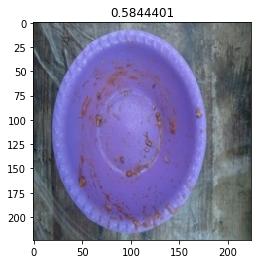

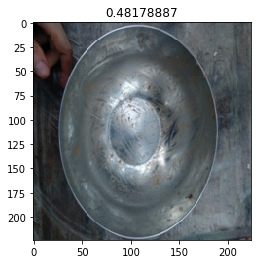

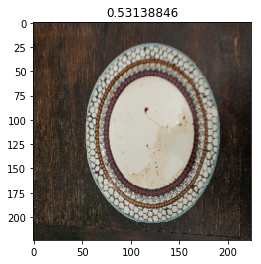

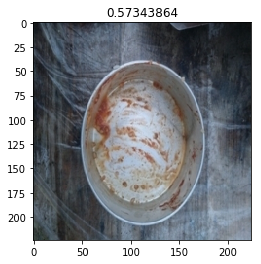

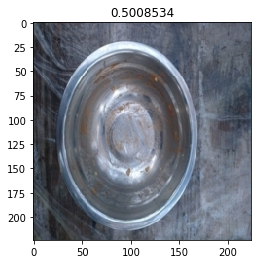

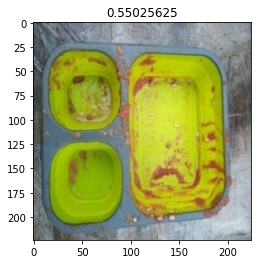

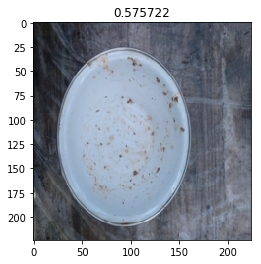

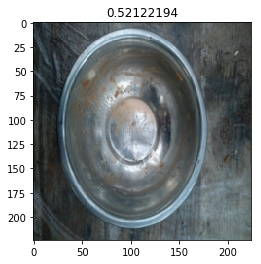

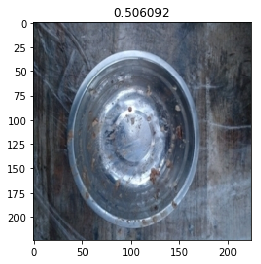

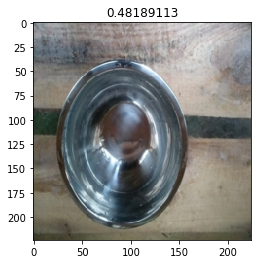

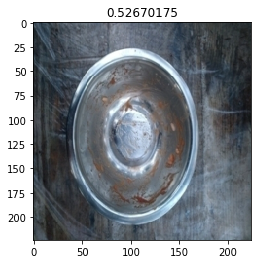

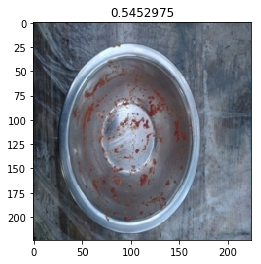

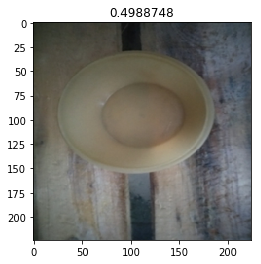

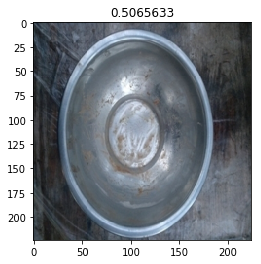

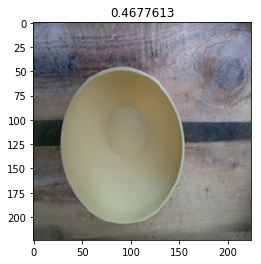

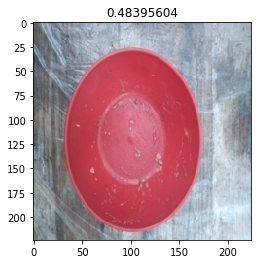

In [20]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [21]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [22]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,cleaned
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [23]:
submission_df.to_csv('submission.csv')

In [24]:
!rm -rf train val test